
# 图解 RoPE（Rotary Position Embedding）

> 目标：用最少的数学把 RoPE 的关键性质讲清楚，并用小实验“看见”这些性质。  
---

## 目录
1. 为什么需要位置编码（没有位置时 Attention 会“位置无关”）
2. RoPE 的核心目标：用“绝对位置注入”实现“相对位置可感知”
3. 二维推导：旋转矩阵如何让点积只依赖相对位置
4. 推广到多维：两两一组旋转 + 多频率（base）设置
5. 实验 1：二维向量随位置旋转（真正“转起来”）
6. 实验 2：验证相对位置性质 $(R_m q)^\top (R_n k)$ 只与 $n-m$ 有关
7. 实验 3：远程衰减与 base 扫描（为什么 base 影响长程注意力）
8. （可选）Toy Attention 可视化：无位置 vs RoPE 的注意力分布


In [1]:

# %%
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

def dot(a, b):
    return float(np.dot(a, b))

def rot2(theta):
    # 2D rotation matrix, counter-clockwise by theta (radians)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]], dtype=np.float64)

def rope_2d(x, pos, omega=1.0):
    # 2D RoPE: rotate x by (pos * omega)
    return rot2(pos * omega) @ x



## 1. 为什么需要位置编码？

Transformer 的注意力核心分数（省略缩放）是：

$
\mathrm{score}(i,j)=q_i^\top k_j
$

如果我们只把 token embedding 喂给模型（没有任何位置信息），那么 **同样的两个 token 向量** 无论放在序列的什么位置，它们的 $q^\top k$ 都一样。

这会导致“位置无关”：模型很难仅凭注意力分数区分“离我近的词”和“离我远的词”。

下面用一个最小 toy 示例感受一下：我们把同一个 $q,k$ 放到不同位置上（但向量值一样），注意力分数不变。


In [2]:

# %%
rng = np.random.default_rng(0)
q = rng.normal(size=(8,))
k = rng.normal(size=(8,))

for (i, j) in [(0, 1), (0, 10), (5, 6), (100, 3)]:
    print(f"pos i={i:>3}, j={j:>3}, score=q^T k = {dot(q,k):.6f}")


pos i=  0, j=  1, score=q^T k = -1.467987
pos i=  0, j= 10, score=q^T k = -1.467987
pos i=  5, j=  6, score=q^T k = -1.467987
pos i=100, j=  3, score=q^T k = -1.467987



---

## 2. RoPE 的核心目标：绝对注入 → 相对可感知

我们想定义一个位置注入函数 \(f(x, p)\)，把一个向量 \(x\) 放到位置 \(p\) 后变成 \(f(x,p)\)，并且希望：

$
f(q,m)^\top f(k,n)
$

能够只依赖 **相对位置** $(n-m)$（当然还依赖 $q,k$ 本身）。

RoPE 的关键点：**用旋转实现位置注入**。二维情况下：

$
f(x,p)=R(p\theta)\,x
$

其中 $R(\cdot)$ 是二维旋转矩阵。下面我们推导为什么它能让点积只依赖 $(n-m)$。



## 3. 二维推导：旋转矩阵带来“相对位置”性质

二维旋转矩阵：

$
R(\alpha)=\begin{bmatrix}
\cos\alpha & -\sin\alpha\\
\sin\alpha & \cos\alpha
\end{bmatrix}
$

它有两个重要性质：

1) $R(\alpha)^\top = R(-\alpha)$  
2) $R(\alpha)^\top R(\beta) = R(\beta-\alpha)$

对 q 和 k 注入绝对位置：

$
\tilde q = R(m\theta) q,\qquad \tilde k = R(n\theta) k
$\]$

点积：

$
\tilde q^\top \tilde k 
= q^\top R(m\theta)^\top R(n\theta) k
= q^\top R((n-m)\theta)\,k
$

因此它只依赖相对位置 $(n-m)$。

下面用代码验证这个恒等式的数值正确性。


In [3]:

# %%
rng = np.random.default_rng(1)
q2 = rng.normal(size=(2,))
k2 = rng.normal(size=(2,))
theta = 0.7

max_err = 0.0
for m in range(0, 50):
    for n in range(0, 50):
        left = dot(rope_2d(q2, m, omega=theta), rope_2d(k2, n, omega=theta))
        right = dot(q2, rope_2d(k2, n-m, omega=theta))
        max_err = max(max_err, abs(left - right))

print(f"max absolute error = {max_err:.3e} (should be near numerical precision)")


max absolute error = 6.356e-15 (should be near numerical precision)



---

## 4. 推广到多维：两两一组旋转 + 多频率（base）

实际模型向量维度 \(d\) 往往很大。RoPE 的做法是：

- 把维度两两分组（每组 2 维）
- 每组做一次二维旋转
- 不同组用不同角速度（多频率），通常：

$
\omega_i = \text{base}^{-2i/d},\qquad \text{angle}_i = p\cdot \omega_i
$

下面给出“纯 numpy”的 RoPE 实现（按稀疏旋转矩阵的等价实现）。


In [15]:

# %%
def rope_omegas(d, base=10000.0):
    assert d % 2 == 0
    i = np.arange(0, d//2, dtype=np.float64)
    return base ** (-2.0 * i / d)

def apply_rope(x, pos, base=10000.0):
    d = x.shape[0]
    assert d % 2 == 0
    omegas = rope_omegas(d, base=base)
    angles = pos * omegas
    c = np.cos(angles)
    s = np.sin(angles)

    x2 = x.reshape(d//2, 2)
    x0 = x2[:, 0]
    x1 = x2[:, 1]
    # print("angles:", angles)
    # print("cosines:", c)
    # print("sines:", s)
    # print("x0:", x0)
    # print("x1:", x1)
    y0 = x0 * c - x1 * s
    y1 = x0 * s + x1 * c
    return np.stack([y0, y1], axis=1).reshape(d)

x = np.array([1,2,3,4], dtype=np.float64)
print("x:", x)
print("RoPE(x,pos=1):", apply_rope(x, pos=1, base=10000.0))


x: [1. 2. 3. 4.]
RoPE(x,pos=1): [-1.1426  1.9221  2.9599  4.0298]



---

## 5. 实验 1：二维向量随位置旋转（“转起来”）


Rotated points:
 [[ 1.      0.2   ]
 [ 0.8812  0.5133]
 [ 0.6674  0.7711]
 [ 0.3815  0.9458]
 [ 0.0544  1.0184]
 [-0.2785  0.981 ]
 [-0.5814  0.8379]
 [-0.8215  0.6043]
 [-0.973   0.3055]
 [-1.0195 -0.0263]
 [-0.9559 -0.3552]
 [-0.7892 -0.6458]
 [-0.5374 -0.8667]
 [-0.2275 -0.9941]
 [ 0.1069 -1.0142]
 [ 0.4298 -0.9248]
 [ 0.7063 -0.7357]
 [ 0.9065 -0.4671]
 [ 1.009  -0.1482]
 [ 1.0026  0.1868]]


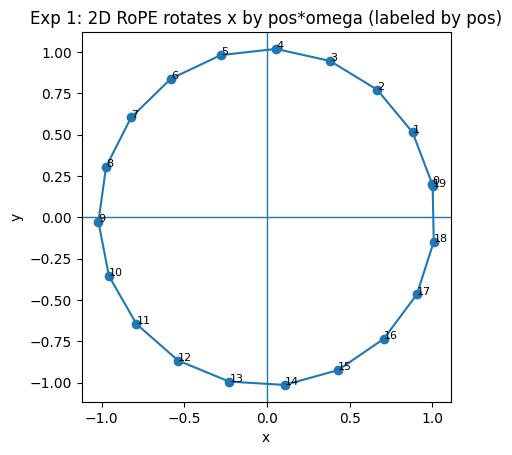

In [12]:

# %%
x = np.array([1.0, 0.2])
omega = 0.33
positions = np.arange(0, 20)

pts = np.stack([rope_2d(x, p, omega=omega) for p in positions], axis=0)
print("Rotated points:\n", pts)
plt.figure()
plt.plot(pts[:,0], pts[:,1], marker="o")
for i, p in enumerate(positions):
    plt.text(pts[i,0], pts[i,1], str(p), fontsize=8)
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Exp 1: 2D RoPE rotates x by pos*omega (labeled by pos)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



---

## 6. 实验 2：相对位置性质（多维版）

固定 $\Delta=n-m$，随机选不同 $(m,n)$ 对，比较分数是否一致。


In [16]:

# %%
rng = np.random.default_rng(2)
d = 64
q = rng.normal(size=(d,))
k = rng.normal(size=(d,))
base = 10000.0

def score(m, n):
    return dot(apply_rope(q, m, base), apply_rope(k, n, base))

delta = 37
pairs = [(0, delta), (10, 10+delta), (123, 123+delta), (999, 999+delta)]
vals = np.array([score(m, n) for (m, n) in pairs])

print("scores with same (n-m)=delta:", vals)
print("max-min:", vals.max() - vals.min())


scores with same (n-m)=delta: [-5.6763 -5.6763 -5.6763 -5.6763]
max-min: 1.0125233984581428e-13



---

## 7. 实验 3：远程衰减与 base 扫描

- 单频率（对照组）：所有组共享同一个 omega  
- 多频率（标准 RoPE）：扫描不同 base

这段实验本质是在看一件事：

> **把位置编码“塞进” Q/K 之后，$q(0)^\top k(t)$ 会不会随着相对距离 (t) 变远而“变小”（远程衰减）？base 会怎么影响这种趋势？**

### 你在画的量到底是什么？

你画的是（把 RoPE 看成一个线性变换 ($R_t$)）：

$
s(t)=\langle \mathrm{RoPE}(q,0), \mathrm{RoPE}(k,t)\rangle
$

因为 ($\mathrm{RoPE}(q,0)=q$)，所以其实是：

$
s(t)= q^\top, R_t, k
$

这里 ($R_t$) 不是一个“整体旋转”，而是 **把向量按维度两两分组**，第 (i) 组做一个角度为 ($t\omega_i$) 的二维旋转。

---

## 图 1：单频率（constant omega）为什么“不衰减”？

你在 `apply_rope_const_omega` 里让所有组共享同一个角速度 ($\omega$)。这意味着：

* 每个二维小块都在转同一个角度 ($t\omega$)
* 等价于对整个 (d) 维向量做了一个“块对角”旋转（每块同角）

于是 (s(t)) 变成了一个“单一频率”的正弦/余弦组合，整体行为很像：

$
s(t)\approx A\cos(t\omega)+B\sin(t\omega)
$

**只有震荡，没有“越远越小”的包络**。
因为所有维度组“相位同步”，不会彼此抵消、也不会越来越“去相干”。

直觉：**大家一起整齐划一地转圈，不会越转越乱**。

---

## 图 2：多频率（标准 RoPE）为什么会出现“远程衰减（看起来像）”？

标准 RoPE 里每组角速度不同：

$
\omega_i = \text{base}^{-2i/d}
$

于是

$
s(t)=\sum_{i=0}^{d/2-1} \underbrace{q_i^\top R(t\omega_i) k_i}_{\text{第 i 组的贡献}}
$

每一组贡献都是“一个频率为 ($\omega_i$) 的正弦/余弦波”。当你把很多不同频率的波**加在一起**：

* (t) 小时：相位差还不大，很多项能“同向”贡献，波动明显
* (t) 大时：不同 ($\omega_i$) 让相位逐渐错开，**正负贡献开始互相抵消**
* 抵消越明显，整体振幅越小，看起来就像“远程衰减”

关键点：

> 这里的“衰减”不是某个单项真的变小，而是**多频率叠加造成的相消**（phase cancellation / 去相干）。

---

## base 为什么会影响衰减强弱？

因为 base 控制了所有 ($\omega_i$) 的范围与密度：

* **base 越大** ⇒ ($\omega_i$) 整体更小，频率更低
  ⇒ 相位 ($t\omega_i$) 随 (t) 增长得更慢
  ⇒ 不同组之间“错相位/去相干”发生得更慢
  ⇒ **衰减更弱（更“耐久”）**

* **base 太小（如 10/100）** ⇒ 高频太多，相位很快乱掉
  ⇒ 你看到的曲线会变得“很快乱震/甚至形状怪”，不再是好看的“震荡衰减”

所以你文章里那句“base 大于 500 时衰减逐渐削弱；base 太小会破坏衰减形态”就是这个原因。


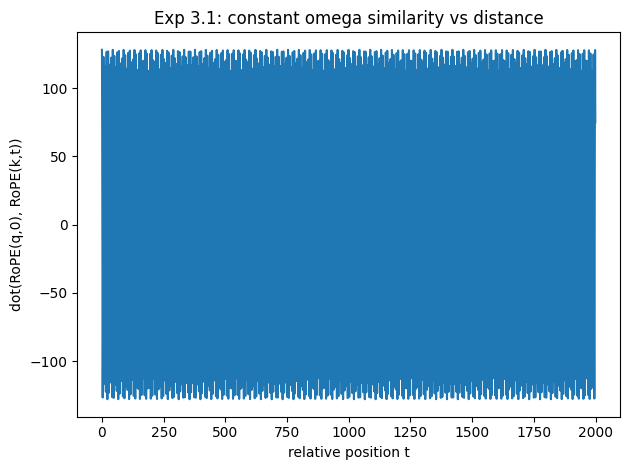

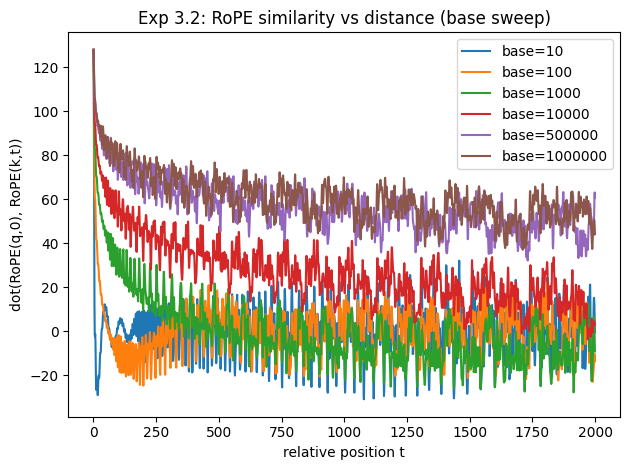

In [23]:

# %%
d = 128
q = np.ones(d, dtype=np.float64)
k = np.ones(d, dtype=np.float64)
T = 2000
ts = np.arange(0, T)

omega_const = 1.0
def apply_rope_const_omega(x, pos):
    x2 = x.reshape(d//2, 2)
    angle = pos * omega_const
    c, s = np.cos(angle), np.sin(angle)
    x0, x1 = x2[:,0], x2[:,1]
    y0 = x0 * c - x1 * s
    y1 = x0 * s + x1 * c
    return np.stack([y0, y1], axis=1).reshape(d)

scores_const = np.array([dot(apply_rope_const_omega(q, 0), apply_rope_const_omega(k, t)) for t in ts])

plt.figure()
plt.plot(ts, scores_const)
plt.title("Exp 3.1: constant omega similarity vs distance")
plt.xlabel("relative position t")
plt.ylabel("dot(RoPE(q,0), RoPE(k,t))")
plt.tight_layout()
plt.show()

bases = [10.0, 100.0, 1000.0, 10000.0, 500000.0, 1000000.0]
plt.figure()
for base in bases:
    scores = np.array([dot(apply_rope(q, 0, base), apply_rope(k, t, base)) for t in ts])
    plt.plot(ts, scores, label=f"base={int(base)}")
plt.title("Exp 3.2: RoPE similarity vs distance (base sweep)")
plt.xlabel("relative position t")
plt.ylabel("dot(RoPE(q,0), RoPE(k,t))")
plt.legend()
plt.tight_layout()
plt.show()


---

## 8.1D RoPE扩展为适配图像的2D RoPE
把 1D RoPE（只有一个位置 (p)）扩展到图像 2D 网格（行列位置 ((m,n))）时，最常用、也最干净的一种做法叫 **Axial / 2D RoPE**：

> **把 head dim 分成两块：一块专门给 x(列) 旋转，一块专门给 y(行) 旋转。**
> 这样点积会只依赖 ($\Delta m, \Delta n$)，也就是二维相对位移。

---

### 1) 2D RoPE 的目标（和 1D 一样，只是相对位移变成二维）

对于图像 patch（或像素）有坐标：

* query 在 ($m_1, n_1$)
* key 在 ($m_2, n_2$)

我们希望 attention logit 里带上二维相对位移：

$
\langle f(q,(m_1,n_1)),, f(k,(m_2,n_2))\rangle
\quad\text{只依赖}\quad
(\Delta m, \Delta n)=(m_2-m_1,,n_2-n_1)
$

---

### 2) 最常用的 2D RoPE：Axial 分解（按维度拆成 x/y 两套旋转）

令 head dim 为 (d)，要求 (d) 能被 4 整除（最方便），把它切成两半：

* 前半维度 ($d_x=d/2$)：编码 **列方向 n**
* 后半维度 ($d_y=d/2$)：编码 **行方向 m**

对一个向量 ($x\in\mathbb{R}^d$)，拆成：
$
x = [x^{(x)};; x^{(y)}]
$

定义 2D RoPE：

$\mathrm{RoPE}_{2D}(x,(m,n))=\big[\mathrm{RoPE}*{1D}(x^{(x)}, n);;\mathrm{RoPE}*{1D}(x^{(y)}, m)\big]$

也就是：**x 部分按列坐标旋转，y 部分按行坐标旋转**。

---

### 3) 为什么它会只依赖 ($\Delta m,\Delta n$)？（一句话证明）

因为每一半都是正交旋转，所以：


$\langle \mathrm{RoPE}*{1D}(q^{(x)},n_1), \mathrm{RoPE}*{1D}(k^{(x)},n_2)\rangle=\langle q^{(x)}, R_x(\Delta n),k^{(x)}\rangle$



$\langle \mathrm{RoPE}*{1D}(q^{(y)},m_1), \mathrm{RoPE}*{1D}(k^{(y)},m_2)\rangle=\langle q^{(y)}, R_y(\Delta m),k^{(y)}\rangle$

两块相加得到整体点积只依赖 ($\Delta n,\Delta m$)。
所以它实现的是 **二维相对位置**（而不是绝对位置）。

### 4) 怎么接到 “图像 attention” 里？

如果你的 patch grid 是 ($H\times W$)，序列长度 ($L=H\cdot W$)。

对第 i 个 patch：

```python
row_i, col_i = idx_to_2d(i, W)
Q2[i] = apply_rope_2d(Q[i], row_i, col_i, base)
K2[i] = apply_rope_2d(K[i], row_i, col_i, base)
```

然后照常算：
$
\text{scores} = Q2 K2^\top / \sqrt d
$

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def rope_omegas(d, base=10000.0):
    assert d % 2 == 0
    i = np.arange(0, d//2, dtype=np.float64)
    return base ** (-2.0 * i / d)

def apply_rope_1d(x, pos, base=10000.0):
    """
    x: [d] (d even)
    """
    d = x.shape[0]
    assert d % 2 == 0
    omegas = rope_omegas(d, base=base)        # [d/2]
    angles = pos * omegas                     # [d/2]
    c = np.cos(angles); s = np.sin(angles)

    x2 = x.reshape(d//2, 2)
    x0 = x2[:,0]; x1 = x2[:,1]
    y0 = x0 * c - x1 * s
    y1 = x0 * s + x1 * c
    return np.stack([y0, y1], axis=1).reshape(d)

def apply_rope_2d(x, row, col, base=10000.0):
    """
    2D (axial) RoPE:
      - 前半维度编码 col
      - 后半维度编码 row
    要求 d % 4 == 0（保证每半还能两两分组旋转）
    """
    d = x.shape[0]
    assert d % 4 == 0
    half = d // 2
    x_col = x[:half]
    x_row = x[half:]
    return np.concatenate([
        apply_rope_1d(x_col, pos=col, base=base),
        apply_rope_1d(x_row, pos=row, base=base),
    ], axis=0)

def softmax(a, axis=-1):
    a = a - a.max(axis=axis, keepdims=True)
    ea = np.exp(a)
    return ea / ea.sum(axis=axis, keepdims=True)


In [28]:
rng = np.random.default_rng(0)

H, W = 8, 8
L = H * W
d = 64  # 必须 d % 4 == 0

q = rng.normal(size=(d,))
k = rng.normal(size=(d,))

base = 10000.0
dr, dc = 2, -3  # 固定相对位移

def score_at(r1, c1, r2, c2):
    q2 = apply_rope_2d(q, r1, c1, base)
    k2 = apply_rope_2d(k, r2, c2, base)
    return float(q2 @ k2)

# 取一些满足 (r2-r1=dr, c2-c1=dc) 的位置对
vals = []
pairs = []
for r1 in range(H):
    for c1 in range(W):
        r2, c2 = r1 + dr, c1 + dc
        if 0 <= r2 < H and 0 <= c2 < W:
            vals.append(score_at(r1, c1, r2, c2))
            pairs.append(((r1,c1),(r2,c2)))

vals = np.array(vals)
print("num valid pairs:", len(vals))
print("scores (first 8):", vals[:8])
print("max-min:", vals.max() - vals.min(), "(应接近 0，误差来自数值精度)")
print("example pairs:", pairs[:5])


num valid pairs: 30
scores (first 8): [-7.2186 -7.2186 -7.2186 -7.2186 -7.2186 -7.2186 -7.2186 -7.2186]
max-min: 3.552713678800501e-15 (应接近 0，误差来自数值精度)
example pairs: [((0, 3), (2, 0)), ((0, 4), (2, 1)), ((0, 5), (2, 2)), ((0, 6), (2, 3)), ((0, 7), (2, 4))]



---

## 9.（可选）Toy Attention：无位置 vs RoPE 的注意力分布


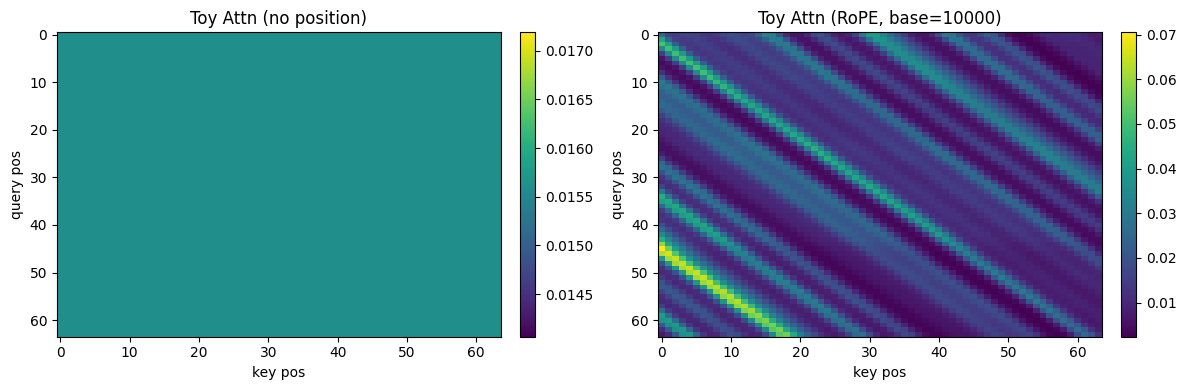

In [25]:

# %%
rng = np.random.default_rng(3)

L = 64
d = 64
x = np.tile(rng.normal(size=(1,d)), (L,1)) 

Wq = rng.normal(size=(d, d)) / np.sqrt(d)
Wk = rng.normal(size=(d, d)) / np.sqrt(d)

Q = x @ Wq
K = x @ Wk

def softmax(a, axis=-1):
    a = a - a.max(axis=axis, keepdims=True)
    ea = np.exp(a)
    return ea / ea.sum(axis=axis, keepdims=True)

scores_plain = (Q @ K.T) / np.sqrt(d)
attn_plain = softmax(scores_plain, axis=-1)

base = 10000.0
Q_rope = np.stack([apply_rope(Q[i], i, base) for i in range(L)], axis=0)
K_rope = np.stack([apply_rope(K[i], i, base) for i in range(L)], axis=0)
scores_rope = (Q_rope @ K_rope.T) / np.sqrt(d)
attn_rope = softmax(scores_rope, axis=-1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(attn_plain, aspect="auto")
plt.title("Toy Attn (no position)")
plt.xlabel("key pos"); plt.ylabel("query pos")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(attn_rope, aspect="auto")
plt.title(f"Toy Attn (RoPE, base={int(base)})")
plt.xlabel("key pos"); plt.ylabel("query pos")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



---

## 小结（三句话）

1) RoPE 的位置注入本质是：把向量按位置旋转（二维旋转 → 多维两两一组旋转）。  
2) 旋转矩阵的正交性质保证：$(R_m q)^\top(R_n k)$ 只依赖相对位置 $(n-m)$。  
3) 多频率（base）让不同维度组相位变化速率不同，叠加后更容易出现“震荡 + 包络衰减”；base 越大衰减越弱，也会影响长度外推行为。
